In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
import helpers
from helpers import *
import pickle
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
from IPython.display import Image
from collections import Counter
import random
    
'''   
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
'''

'   \ndef fxn():\n    warnings.warn("deprecated", DeprecationWarning)\n\nwith warnings.catch_warnings():\n    warnings.simplefilter("ignore")\n    fxn()\n'

In [2]:
%pwd

'/Users/thomasspringett/github/heartrate'

# Setting Configuration and Limit Parameters

## Hardware Limits, Sample Size, Maximum HR 

The heart rate data was obtained from an Apple Watch and exported from Healthkit. The watch sensor's valid limits are from 30 bpm to 210 bpm. Values outside of this range are filtered. Do to the large database with over 349,000 data points, a random sample was generated. This did not significantly affect the distribution or results but did improve execution time. 

Maximum heart can be calculated from age. The formula is 220-age. There is no comparable algorithm for minimum heart rate. In general, a lower resting heart rate is indicative of better conditioning. 

In [3]:
# Configuration Parameters including hardware sensor limits, maximum heart rate and sample size are defined. 
# To calculate maximum heart rate, the formula 220 - age is used. 
age = 63 
max_hr = 220-age
sample_size = 10000
hardware_upper_limit = 210
hardware_lower_limit = 30

## Heart Rate Zone Limits from the CDC, Mayo Clinic and Polar (tm)

Various heart rate zones have been defined from resting heart rates to high intensity heart rates. There is no standard. Polar heart rate monitors have been in use by atheletes for decades. They define 5 zones with the highest zone reserved for high intensity workouts from elite atheletes. The CDC and Mayo clinic define two exercise zones, moderate and intense. The resulting of the clusting algortihms will be compared to these 3 different sources. 
The limits for these zones are defined in a dictionary below: 

In [4]:
#Dictionaries are defined for Mayo Clinic, CDC and Polar (tm) heart rate zones: 
mayo_limits = {'moderate_low':0.50*max_hr,'moderate_hi':0.7*max_hr,'intensity_low':0.70*max_hr,'intensity_hi':0.85*max_hr}
cdc_limits = {'moderate_low':0.64*max_hr,'moderate_hi':0.76*max_hr,'intensity_low':0.76*max_hr,'intensity_hi':0.93*max_hr}
polar_limits = {'zone1':0.6*max_hr,'zone2':0.7*max_hr,'zone3':0.80*max_hr,'zone4':0.9*max_hr,'zone5':1*max_hr}

# Loading and Pre-Processing the Data

The dataset is from one 63 year old white male exported from the Apple Health app. A default field list is generated. Unfortunetly, attributes such as activity type, are not collected. For this project, only the heart rate, in beats per minute (bpm), will be analyzed.  

In [5]:
# The dataset for this project consist of heart rate data collected over 4 years 
# during various physical activities: biking, walking, skiing. 
csv_file = 'data/HeartRateDataRaw.csv'
df_raw = pd.read_csv(csv_file, header=0)

/Users/thomasspringett/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Displaying the list of column names in the heart rate export: 
for col in df_raw.columns:
    print (col)

/@locale
/ExportDate/@value
/Me/@HKCharacteristicTypeIdentifierBiologicalSex
/Me/@HKCharacteristicTypeIdentifierBloodType
/Me/@HKCharacteristicTypeIdentifierDateOfBirth
/Me/@HKCharacteristicTypeIdentifierFitzpatrickSkinType
/Record/@creationDate
/Record/@device
/Record/@endDate
/Record/@sourceName
/Record/@sourceVersion
/Record/@startDate
/Record/@type
/Record/@unit
/Record/@value
/Record/MetadataEntry/@key
/Record/MetadataEntry/@value
/Record/MetadataEntry/@value/#agg


In [7]:
# Saving and renaming only the BPM values: 
df_raw = df_raw.filter(items=['/Record/@value'])
df_raw = df_raw.rename(columns={'/Record/@value':"BPM"})

## Explore the Data
With the data of interest selected, it is now time to explore the data. A display of the raw dataframe, summary
statistics and graphical analysis will all be used to understand the dataset. 

In [8]:
# The summary statistics for heart rate data on the full dataset: 
display (round(df_raw.BPM.describe()))

count    349781.0
mean         78.0
std          24.0
min           5.0
25%          61.0
50%          69.0
75%          86.0
max         215.0
Name: BPM, dtype: float64

In [9]:
#To improve execution times, a random sample of 10,000 from the population of 349,768 is drawn. By comparing the 
#percentiles of the population above to that of the sample below, it can be seen the sample actuately 
#reflects the population. 

df_s=random.sample(list(df_raw.BPM), sample_size)
df_sample = pd.DataFrame(df_s)
df_sample.columns=['BPM']
print (round(df_sample.describe()))

           BPM
count  10000.0
mean      78.0
std       24.0
min        6.0
25%       61.0
50%       69.0
75%       86.0
max      215.0


In [10]:
# Now the hardware limits are being applied to the data:

df_limit = df_sample[(df_sample['BPM'] < hardware_upper_limit) & (df_sample['BPM'] > hardware_lower_limit) ]
num_screened = df_sample.shape[0]-df_limit.shape[0]
print ("Applying hardware limit of {}bpm resulted in dropping {} data points.".format(hardware_upper_limit,num_screened))

Applying hardware limit of 210bpm resulted in dropping 11 data points.


In [11]:
 def plot_data_histo(totals): 
    
    '''This method will be used to plot the heart rate distribution. The data will be
       from the 'BPM' column, the same column used for the above summary statistics. 
    '''
    
    xref = [max_hr]
    ref_colors=['r']
    plt.figure(figsize=(5,3))
    for ref, c in zip(xref,ref_colors):
        plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
    plt.legend()
    
    # Setting up the grids: 
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    plt.xlabel('Beats/Minute')
    plt.ylabel('Count')
    plt.title('Raw Heart Rate Distribution')
    #plt.ylim(0,35000)
    #plt.xlim(30,200)
    plt.hist(df_raw.BPM, bins=range(35, 205+2, 2))
    plt.savefig('./plots/raw_histo.png')
    plt.show()

## Pre-Processing Summary
The dataset has been loaded, columns of interest selected, data filtered for valid hardware limits and a smaller sample generated to speed execution. Summary statistics and graphical analysis have also been completed. This is simple 1D dataset with no features or labels.
### Training and Test Sets
Note that the data has not been segregated into training and test sets. This is becaused it is un-supervised learning. There are no labels for model predictions to be compared against. Instead a 'score', explained more below, will be used to evaluate the model with the best fit. 

# Modeling 
## KMeans 
This model was selected as it does not required labeled data and it is intuitive to understand. One primary question to be answered is whether or not a high intensity, high heart rate cluster, separate from lower intensity clusters could be indentified. This would allow for personalized high intensity zones to be defined. 

### Fitting, Predicting and Evaluating the Model
Determining the optimium number of cluster is the first step. Consequently, values from 2 to 10 were used. The data was fit and model predictions were used to define labels. The KMeans performance metric is called its score or inertia. It measures the mean square distance from the instance to the cluster centroid. Lower numbers are considerted to be better. 

In [12]:
def scree_KMeans_plot(data,num_clusters):
    
    ''' This method will calculate Kmeans clusters. The number of clusters will be defined by a range. 
        Kmeans will be used to define the clusters and labels for the data generated. Finally the data 
        will be ploted so the Elbow method can be used to determine the optimum number of clusters. 
    '''
    
    clusterCenters = [] 
    scores = [] 
    k_values = []
    start = timer()
    for k in range(1,num_clusters):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        #print ("\nCluster {}: {}".format(k,model.cluster_centers_))
        clusterCenters.append(model.cluster_centers_)
        labels = kmeans.predict(data)
        #print ("Cluster Labels: ",np.unique(labels))
        score = -(kmeans.score(data))
        #print ("score: ",round(score/100000000,2))
        scores.append(score)
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Elbow Method: Number of Clusters vs KMeans Score')
    plt.savefig('./plots/Cluster_vs_score_plot.png')
    plt.show()
    end = timer() 
    #print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    return k_values, scores, labels

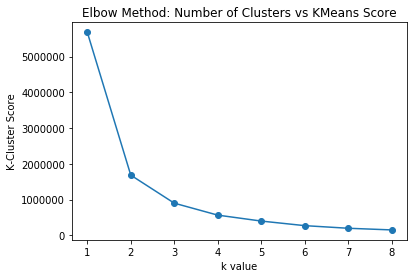

In [13]:
k_values, scores, labels = scree_KMeans_plot(df_sample,9) 

In [14]:
print ("KMeans Labels: ",np.unique(labels)) 

KMeans Labels:  [0 1 2 3 4 5 6 7]


#### KMeans Score or Inertia
For each of the clusters numbered 2 to 10, the score was calculated and compared to k. The plot is above. It can be seen that after 5 clusters the improvment in score diminishes. This rather crude method, also called the Elbow method, suggests that after 5 clusters the improvement diminishes. 5 cluster would also make the comparison to the Polar (tm) methodology straight forward.

Another method, listed below, was written to specify a percentage improvement in the score at which the addition of more clusters is no longer beneficial.  

In [32]:
# The elbow method would suggest that most of the improvement in the cluster scores happens prior to k=5.
# The algorithm below allows for selection of k based on the diminishing benefits of increasing clusters. 
# 5 clusters is being chosen, not just by the elbow method above as it also matches up with the 5 zones 
# defined by the Polar (tm) methodology. 

def findK(df,limit): 

    for k in range(len(df)):
        if k == len(df):
           print ("\nEnd of array reached.") 
        elif k == len(df): 
          improvement = 'None'
          print ("end of array reached prior to limit")
          print ("K=0")
        elif k > 0:
          improvement = (round(100*((df[k-1]-df[k])/df[k])))
          #print (k,round(df[k]/100000000,2),improvement)
          if improvement < limit:
                #print ("Improvement of {}% is less than lower limit of {}% for k = {}. k max is {} ".format(improvement,limit,k,len(df)))
                break
    print ("Maximum value of number of clusters (k) is: ",len(df))
    print ("Less than {}% improvement in score after k = {}".format(limit,k))
findK(scores,39.5) 

Maximum value of number of clusters (k) is:  8
Less than 39.5% improvement in score after k = 6


#### KMeans Silhouette Score
A second performance metric was also used to evaluate the model performance. It is called the silhouette score and is more robust than the inertia score.  It comprehends both cohesion, or intra-cluster distances,  as well as the inter-cluster distances, or separation.

In [37]:
def silhouetteScore(df,num_clusters): 
    sil_scores = [] 
    start = timer()
    range_n_clusters = list(range(2,num_clusters))
    for n_clusters in range_n_clusters:
        #kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(df)
        score = round(silhouette_score(df,cluster_labels),2)
        sil_scores.append(score)
        print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
        end=timer()
        #print(f"Function in {(end - start)/60:0.1f} minutes")
    print ("\nFinished!")
    return sil_scores

In [38]:
def silhouette_plot(scores, k_values):
    plt.figure(figsize=(5,3))
    plt.ylabel('Silhouette Score')
    plt.xlabel('k value')
    plt.title('Silhouete For Best K')
    plt.ylim=(0.0,1.0)
    plt.grid(True)
    plt.plot(k_values, scores, marker = 'o')

    plt.show()

In [39]:
%%time
sil_scores = silhouetteScore(df_sample.BPM.values.reshape(-1,1),10)

For n_clusters = 2, silhouette score is 0.7
For n_clusters = 3, silhouette score is 0.61
For n_clusters = 4, silhouette score is 0.59
For n_clusters = 5, silhouette score is 0.55
For n_clusters = 6, silhouette score is 0.56
For n_clusters = 7, silhouette score is 0.55
For n_clusters = 8, silhouette score is 0.56
For n_clusters = 9, silhouette score is 0.55

Finished!
CPU times: user 10.6 s, sys: 1.85 s, total: 12.4 s
Wall time: 12.4 s


In [ ]:
# Prior to plotting the silhouette scores, a check will be done to make sure the arrays are of the same length:

print (len(k_values), len(silhouette))
if len(k_values) > len(silhouette):
    x=len(k_values) - len(silhouette)
    k_values = k_values[:-x]
if len(silhouette) > len(k_values):
    x = len(silhouette) - len(k_values)
    silhouette = silhouette[:-x]
print (len(k_values), len(silhouette))

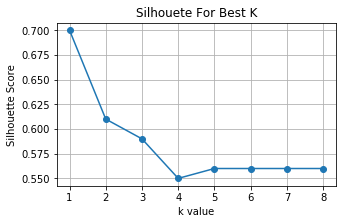

In [34]:
silhouette_plot(silhouette,k_values)

In [19]:
# This method will divide up the bpm histograms by the chosen number of clusters, 5 in this case, 
# and plot the results: 

def hr_cluster_histogram(df): 
    
    if  'Label' in df: 
        df.drop("Label",axis='columns',inplace=True)
    
    kmeans = KMeans(n_clusters=5)
    model = kmeans.fit(df)
    centers = np.round(model.cluster_centers_,0)
    print ("Percent of Values in each zone: ")
    labels = kmeans.predict(df)
    print ("KMeans Labels: ",np.unique(labels))   
   
    df.insert(1,"Label",labels)

    clusterCounts(labels)

    xref = [max_hr]
    ref_colors=['r']
        
    zone1 = df.loc[df.Label ==0, 'BPM']
    zone2 = df.loc[df.Label ==1, 'BPM']
    zone3 = df.loc[df.Label ==2, 'BPM']
    zone4 = df.loc[df.Label ==3, 'BPM']
    zone5 = df.loc[df.Label ==4, 'BPM']
    
    # Setup plot:
    plt.figure(figsize=(5,3))
  
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')

    plt.title('Cluster Heart Rate Distribution')
    plt.hist(zone1,  color='b', label='Cluster 1', bins=range(35, 205, 2))
    plt.hist(zone2,  color='c', label='Cluster 2', bins=range(35, 205, 2))
    plt.hist(zone3,  color='g', label='Cluster 3', bins=range(35, 205, 2))
    plt.hist(zone4,  color='y', label='Cluster 4', bins=range(35, 205, 2))
    plt.hist(zone5,  color='r', label='Cluster 5', bins=range(35, 205, 2))
    plt.legend()
   
    plt.savefig('./plots/cluster_histo.png')
    plt.show()

In [20]:
def hr_polar_histogram(df): 

    zone1 = df.loc[df.Polar_Zone == 'zone1', 'BPM']
    zone2 = df.loc[df.Polar_Zone == 'zone2', 'BPM']
    zone3 = df.loc[df.Polar_Zone == 'zone3', 'BPM']
    zone4 = df.loc[df.Polar_Zone == 'zone4', 'BPM']
    zone5 = df.loc[df.Polar_Zone == 'zone5', 'BPM']
    
    xref = [max_hr]
    ref_colors=['r']
    
    plt.figure(figsize=(5,3))
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

    #plt.grid(True)
    plt.title('Polar(tm) Zone Heart Rate Distribution')
    plt.hist(zone1, **kwargs, color='g', label='Zone 1', bins=range(35, 205+2, 2))
    plt.hist(zone2, **kwargs, color='b', label='Zone 2', bins=range(35, 205+2, 2))
    plt.hist(zone3, **kwargs, color='r', label='Zone 3', bins=range(35, 205+2, 2))
    plt.hist(zone4, **kwargs, color='c', label='Zone 4', bins=range(35, 205+2, 2))
    plt.hist(zone5, **kwargs, color='y', label='Zone 5', bins=range(35, 205+2, 2))
    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    plt.xlim(30,200)
    plt.legend()
    plt.savefig('./plots/zone_histo.png')
    plt.show()

In [45]:
def hr_3zone_histogram(df,source): 

    if source == 'Mayo':
        zone1 = df.loc[df.Mayo_Zone == 'Moderate', 'BPM']
        zone2 = df.loc[df.Mayo_Zone == 'Intensity', 'BPM']
        zone3 = df.loc[df.Mayo_Zone == 'Other', 'BPM']

    
    if source == 'CDC':
        zone1 = df.loc[df.CDC_Zone == 'Moderate', 'BPM']
        zone2 = df.loc[df.CDC_Zone == 'Intensity', 'BPM']
        zone3 = df.loc[df.CDC_Zone == 'Other', 'BPM']


    xref = [max_hr]
    ref_colors=['r']
    bin = 50
    plt.figure(figsize=(5,3))
    # xticks = np.linspace(30, 200, 50)
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    
    #plt.grid(True)

    plt.title(source + ' Clinic Zone Heart Rate Distribution')
        
    plt.hist(zone1, **kwargs, color='g', label='Moderate',bins=range(35, 205+2, 2))
    plt.hist(zone2, **kwargs, color='b', label='Intensity',bins=range(35, 205+2, 2))
    plt.hist(zone3, **kwargs, color='r', label='Other',bins=range(35, 205+2, 2))

    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    plt.xlim(30,200)
    plt.legend()
    if source == 'Mayo': 
        plt.savefig('./plots/mayo_histo.png')
    if source == 'CDC': 
        plt.savefig('./plots/cdc_histo.png')
    plt.show()

 Note that with KMeans clustering the data will not be split into training and test sets. Kmeans clustering is not a classification tool. The data is not labeled.

In [22]:
# The function below calculates the percent of the distribution in each cluster. 
def clusterCounts(labels): 
    #Count number in each cluster for general population 
    clusterDict = collections.Counter(labels)
    clusterSum = sum(clusterDict.values())
    #clusterCounter = Counter(clusterDict.values())

    for key,value in sorted(clusterDict.items()): 
        print (key, ' ->',np.round(100*value/clusterSum),'%')

Percent of Values in each zone: 
KMeans Labels:  [0 1 2 3 4]
0  -> 40.0 %
1  -> 10.0 %
2  -> 16.0 %
3  -> 32.0 %
4  -> 3.0 %


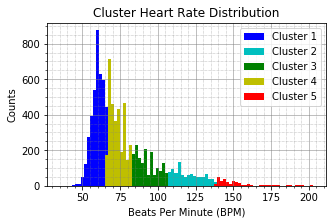

In [23]:
hr_cluster_histogram(df_sample)

In [24]:
def assignZone(value):
    if (value <= polar_limits['zone1']): 
        return "zone1"
    elif (value > polar_limits['zone1']) and (value <= polar_limits['zone2']):
        return "zone2"
    elif (value > polar_limits['zone2']) and (value <= polar_limits['zone3']):
        return  "zone3"
    elif (value > polar_limits['zone3']) and (value <= polar_limits['zone4']):
        return  "zone4"    
    elif (value > polar_limits['zone4']) and (value <= polar_limits['zone5']):
        return "zone5"
    else:
        return 'nan'

In [25]:
print ("CDC Limits: ",int(cdc_limits['moderate_low']),int(cdc_limits['moderate_hi']), int(cdc_limits['intensity_low']),int(cdc_limits['intensity_hi']))
def assignCDCZone(value):
    if (value > cdc_limits['moderate_low']) and (value <= cdc_limits['moderate_hi']):
        return "Moderate"
    elif (value > cdc_limits['intensity_low']) and (value <= cdc_limits['intensity_hi']):
        return  "Intensity"
    else:
        return 'Other'

CDC Limits:  100 119 119 146


In [26]:
print ("Mayo Clinic Limits: ",int(mayo_limits['moderate_low']),int(mayo_limits['moderate_hi']), int(mayo_limits['intensity_low']),int(mayo_limits['intensity_hi']))
def assignMayoZone(value):
    if (value > mayo_limits['moderate_low']) and (value <= mayo_limits['moderate_hi']):
        return "Moderate"
    elif (value > mayo_limits['intensity_low']) and (value <= mayo_limits['intensity_hi']):
        return  "Intensity"
    else:
        return 'Other'

Mayo Clinic Limits:  78 109 109 133


In [27]:
df_zones=df_sample.copy()
df_zones['Polar_Zone'] = df_zones.BPM.apply(assignZone)
df_zones['CDC_Zone'] = df_zones.BPM.apply(assignCDCZone)
df_zones['Mayo_Zone'] = df_zones.BPM.apply(assignMayoZone)
print (df_zones.shape)
df_zones.head()

(10000, 5)


,BPM,Label,Polar_Zone,CDC_Zone,Mayo_Zone
0,62.0,0,zone1,Other,Other
1,67.0,3,zone1,Other,Other
2,73.0,3,zone1,Other,Other
3,87.0,2,zone1,Other,Moderate
4,74.0,3,zone1,Other,Other


In [28]:
#Checking for Zone assignment: 
print (df_zones['Polar_Zone'].unique())
print (df_zones['CDC_Zone'].unique())
print (df_zones['Mayo_Zone'].unique())

['zone1' 'zone2' 'zone3' 'zone4' 'zone5' 'nan']
['Other' 'Intensity' 'Moderate']
['Other' 'Moderate' 'Intensity']


In [29]:
df2 = df_zones.copy() 
print ("The percentiles for Polar Zones:")
clusterCounts(df2['Polar_Zone'])
#clusterCounts(df2['CDC_Zone'])
#clusterCounts(df2['Mayo_Zone'])

The percentiles for Polar Zones:
nan  -> 1.0 %
zone1  -> 81.0 %
zone2  -> 8.0 %
zone3  -> 6.0 %
zone4  -> 4.0 %
zone5  -> 2.0 %


In [ ]:
hr_polar_histogram(df2)

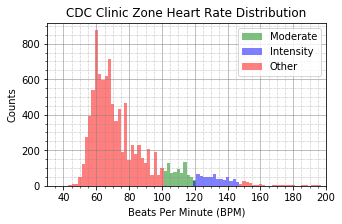

In [46]:
hr_3zone_histogram(df2,'CDC')

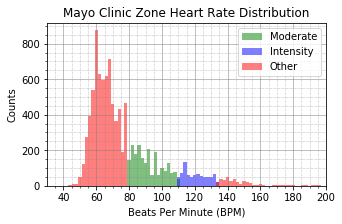

In [44]:
hr_3zone_histogram(df2,'Mayo')

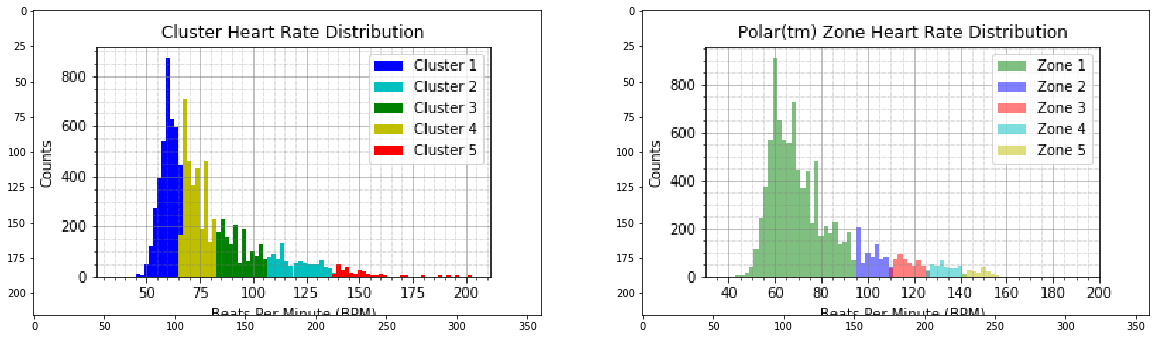

In [40]:
#import matplotlib.image as mpimg
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import imageio
import matplotlib.pyplot as plt

img1  =  imageio.imread('./plots/cluster_histo.png')
img2 = imageio.imread('./plots/zone_histo.png') 
mayo = imageio.imread('./plots/mayo_histo.png')
img2 = imageio.imread('./plots/cdc_histo.png')

plt.rcParams["figure.figsize"] = (20,20)


fig,(ax1,ax2,ax3,ax4) = plt.subplots(2,2)
#plt.subplot(2,1,1)
#plt.figure()

ax1.imshow(img1)                     
#plt.subplot(212) 
ax2.imshow(img2) 




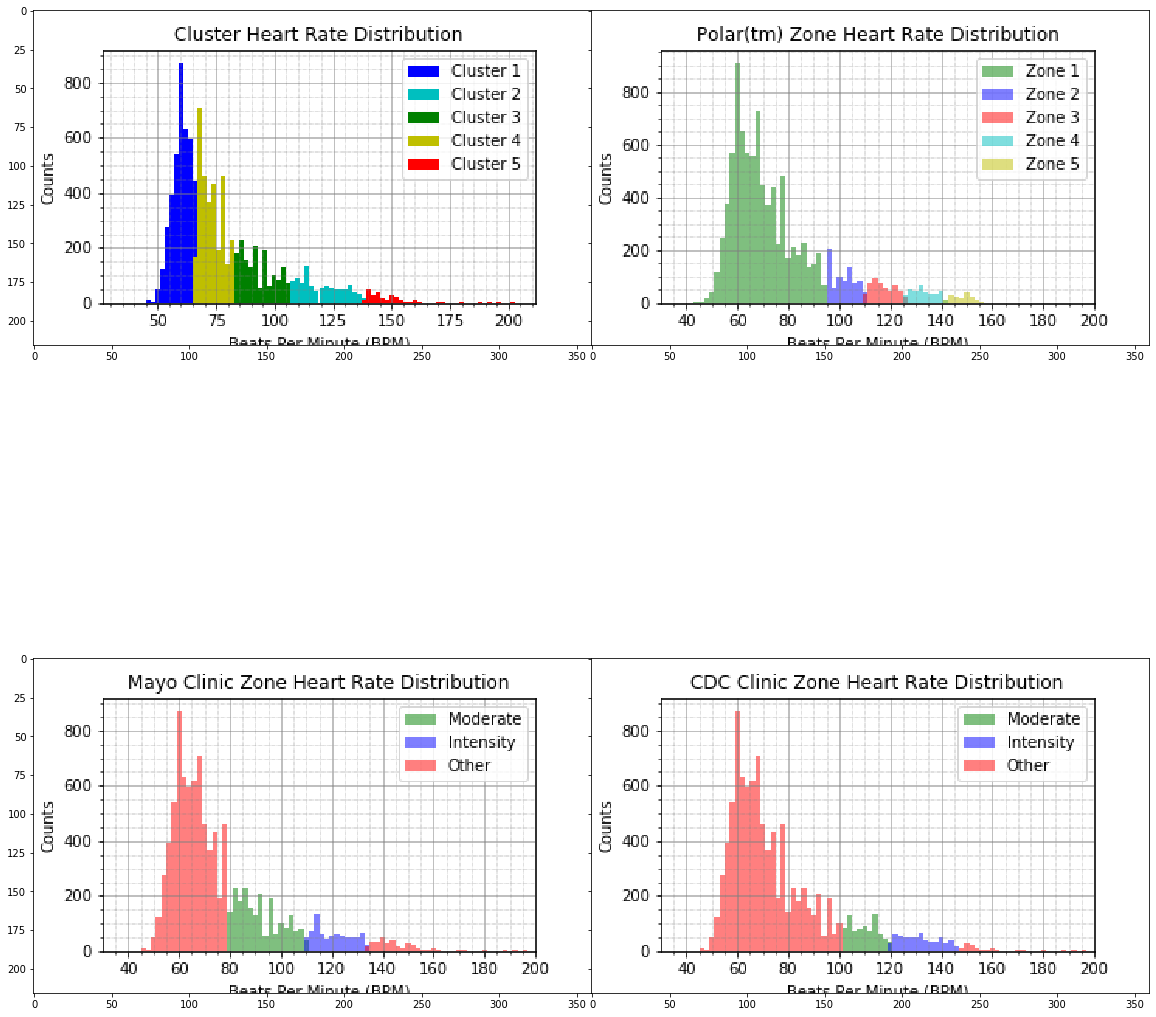

In [57]:
import matplotlib.gridspec as gridspec

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2,sharey=True)

img1 = imageio.imread('./plots/cluster_histo.png')
img2 = imageio.imread('./plots/zone_histo.png') 
img3 = imageio.imread('./plots/mayo_histo.png')
img4 = imageio.imread('./plots/cdc_histo.png')

plt.rcParams["figure.figsize"] = (20,20)
#gs1 = gridspec.GridSpec(4, 4)
#gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes
fig.subplots_adjust(wspace=0, hspace=0,bottom = 0,top = 0.9)

#fig,(ax1,ax2,ax3,ax4) = plt.subplots(2,2)
#plt.subplot(2,1,1)
#plt.figure()

ax1.imshow(img1)                     
#plt.subplot(212) 
ax2.imshow(img2) 
ax3.imshow(img3) 
ax4.imshow(img4) 
plt.show()

In [ ]:
#pickle.dump(sil_scores,open('data/silhouetteScores','wb'))
#silhouette = pickle.load(open('data/silhouetteScores', 'rb'))
#print ("Sil Scores: ",silhouette)

In [ ]:
def silhouette_plot(scores, k_values):
    plt.figure(figsize=(5,3))
    plt.ylabel('Silhouette Score')
    plt.xlabel('k value')
    plt.title('Silhouete For Best K')
    plt.ylim=(0.0,1.0)
    plt.grid(True)
    plt.plot(k_values, scores, marker = 'o')

    plt.show()

In [ ]:

'''
print (len(k_values), len(silhouette))
print (oftype(k_values))
print (oftype(silhouette))
if len(k_values) > len(silhouette):
    x=len(k_values) - len(silhouette)
    k_values = k_values[:-x]
if len(silhouette) > len(k_values):
    x = len(silhouette) - len(k_values)
    silhouette = silhouette[:-x]
oftype(k_values)
print (len(k_values), len(silhouette))
'''


In [ ]:
silhouette_plot(silhouette,k_values)

The first step in determining high intensity heart rate zones is to determine maximum heart rate. There are several methods for this: 

1. 200 - 1/2 age. Or 168bpm for a 62 year old. 
2. 220 - age. 0r 158bpm for a 62 year old.
3. Heart Rate Monitor data collected over a period of months with various activities. 
4. Using a treadmill or stationary bike with an ECG. 

Option number 2 is the most common for folks that do not have access to the treadmill and ECG. It will be used for the remainder of the project. 

After the maximum heart rate is determined, target heart rates can be determined: 
1. Target active heart rate: 60-70%. Or 95 to 110 bpm for the 62 year old. 
2. Target Heart Rate is 64% to 76%. CDC. 
3. High Intensity target heart rate is 76-93% (CDC). Or 120 to 146 for the 62 year old. 
 
The heart rate monitor company Polar suggests 5 heart rate zones: 
1. Very light at 50-60% of HRMAX. Boost recovery and prepare for higher zones.
2. Light 60-70%. Improve general endurance and increase capillary density.
2. Moderate at 70-80%. Lactic acid build up,improve efficiency of blood circulation in the heart and muscles
4. Hard 80-90%. Improve speed endurance.
5. Maximum 90-100%. For elite atheletes to further improve speed. 

The Mayo Clinic defines 
1. Moderate intensity as 50-70% of maximum heart rate.
2. Vigorous as 70% to 85%. 